# fully-connected neural network

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import torch
import torch.nn as nn

2025-01-11 21:32:11.884586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 21:32:11.892083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 21:32:11.900349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 21:32:11.902780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 21:32:11.909203: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2

In [32]:
import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

## dataset

In [6]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# df = df.iloc[:8_000_000,:]
# shuffle rows
df = df.sample(frac=1)
# df['label'] = df['label'].map({'epitope':1, 'other': 0})
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
2184044,HDGHDDDMIDIE,1,-1.500000,0.806667,10.266667,0.144083,3.285833,-15.5,0.465,11.35,...,0,1,0,0,0,0,0,0,0,0
1449938,LCQPKQKIR,0,13.222222,1.074444,8.633333,0.191111,4.080000,-10.0,1.150,10.50,...,1,1,1,1,0,1,0,0,0,0
820712,EVIGSELKHW,1,28.700000,1.054000,8.590000,0.173400,3.767000,4.0,0.880,9.10,...,0,1,1,1,0,0,1,0,0,1
750323,SQLCSLWIESARVIR,1,38.066667,0.998000,7.766667,0.171067,3.686667,41.0,0.610,8.10,...,1,1,1,0,0,0,1,0,0,1
3432546,QDELNRRKNH,0,-9.800000,0.554000,10.660000,0.192100,4.210000,-18.5,0.535,10.90,...,0,0,1,1,0,0,0,0,0,0


In [14]:
X = np.array(df.iloc[:,2:], dtype=np.float16)
y = np.array(df.iloc[:,1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

from collections import Counter
Counter(y)

(3458238, 48) float16 (3458238,) float16


In [16]:
# normalization X
scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

In [17]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, train_size=0.8, shuffle=True, random_state=2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(1936612, 48) (1936612,)
(829978, 48) (829978,)
(691648, 48) (691648,)


## train model

In [18]:
from tensorflow.keras.layers import Input, Dense, Dropout

# input features
num_features = int(X.shape[-1])
# outccome is binary
model = tf.keras.Sequential([
    Input(shape=(num_features,)),
    Dense(2048, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 2048)           │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,198,785 (4.57 MB)

 Trainable params: 1,198,785 (4.57 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy', 'precision', 'recall', 'auc', 'mse'])

epochs = 50
history= model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, verbose=False)

res = pd.DataFrame(history.history)
print(res.head(3))
print(res.tail(3))

KeyboardInterrupt: 

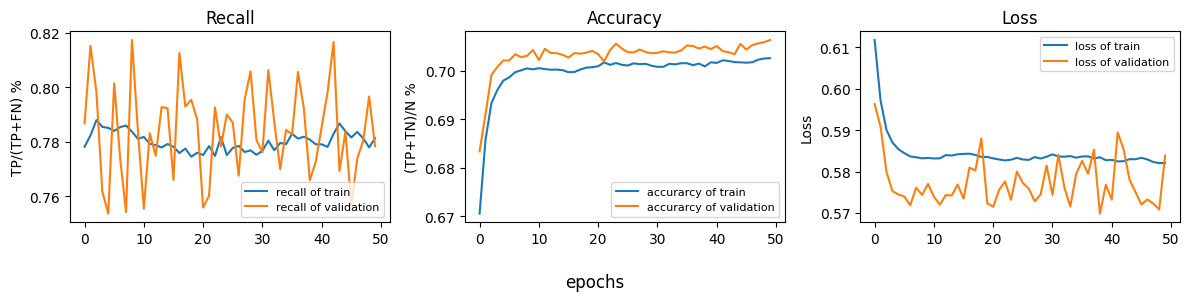

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), layout='tight')
x = range(epochs)
fig.supxlabel('epochs')

i=0
axes[i].plot(x, history.history['recall'], label='recall of train')
axes[i].plot(x, history.history['val_recall'], label='recall of validation')
axes[i].set_ylabel('TP/(TP+FN) %')
axes[i].set_title('Recall')
axes[i].legend(loc='lower right', fontsize=8)

i=1
axes[i].plot(x, history.history['accuracy'], label='accurarcy of train')
axes[i].plot(x, history.history['val_accuracy'], label='accurarcy of validation')
axes[i].set_ylabel('(TP+TN)/N %')
axes[i].set_title('Accuracy')
axes[i].legend(loc='lower right', fontsize=8)

i=2
axes[i].plot(x, history.history['loss'], label='loss of train')
axes[i].plot(x, history.history['val_loss'], label='loss of validation')
axes[i].set_ylabel('Loss')
axes[i].set_title('Loss')
axes[i].legend(loc='upper right', fontsize=8)

In [21]:
eval_res = model.evaluate(X_test, y_test, return_dict=True)
print(eval_res)

21614/21614 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.7066 - auc: 0.7703 - loss: 0.5836 - mse: 0.1986 - precision: 0.7064 - recall: 0.7792
{'accuracy': 0.7063043713569641, 'auc': 0.7700528502464294, 'loss': 0.5836716294288635, 'mse': 0.19860048592090607, 'precision': 0.7067002654075623, 'recall': 0.7786230444908142}


In [22]:
pred_test = model.predict(X_test)
pred_test[:3]

21614/21614 ━━━━━━━━━━━━━━━━━━━━ 8s 350us/step


array([[0.65177435],
       [0.49418548],
       [0.53432125]], dtype=float32)

Text(0.5, 1.0, 'Prediction of non-epitopes 318601')

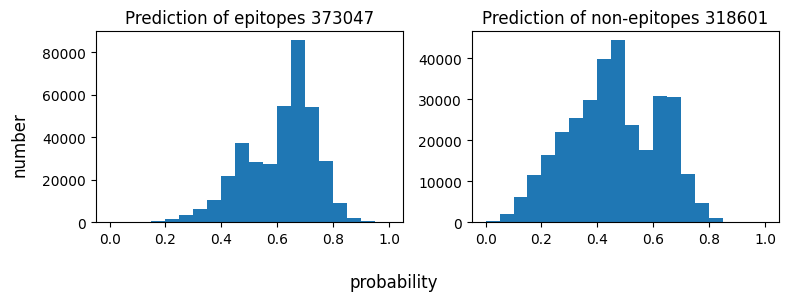

In [23]:

t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of epitopes {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of non-epitopes {len(f)}')

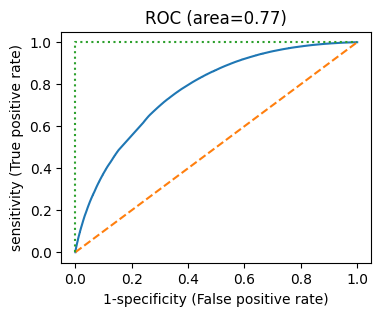

In [31]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')

In [26]:
# save entire model
model.save('../models/epitopes_ann.keras')

(array([  2355.,  18739.,  43809.,  72180., 143544.,  96858., 201924.,
         99382.,  12398.,    459.]),
 array([0.        , 0.09999919, 0.19999838, 0.29999757, 0.39999676,
        0.49999595, 0.59999514, 0.69999433, 0.79999352, 0.8999927 ,
        0.99999189]),
 <BarContainer object of 10 artists>)

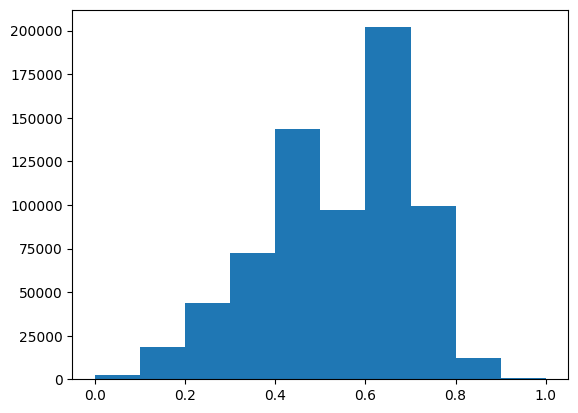

In [29]:
plt.hist(pred_test)

(array([318601.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 373047.]),
 array([0.        , 0.09997559, 0.19995117, 0.30004883, 0.39990234,
        0.5       , 0.60009766, 0.70019531, 0.79980469, 0.89990234,
        1.        ]),
 <BarContainer object of 10 artists>)

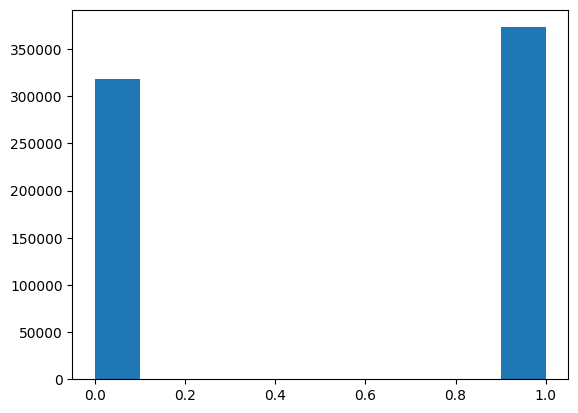

In [30]:
plt.hist(y_test)